<a href="https://colab.research.google.com/github/dolmani38/ai_corona/blob/master/analysis_corona_0509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 분석에 필요한 많이 쓰는 함수 미리 정의

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import model_from_json
import numpy as np
import scipy as sp
import scipy.stats
from datetime import datetime, timedelta

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def plot_train_result(hist):
    """
    학습의 결과, epoch 당 mean_absolute_error, R square, accuracy 등의 값을 Chart로 나타낸다.
    :param hist: hist = model.fit(....)
    :return:
    """
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    if 'mae' in hist.history:
        color = 'tab:red'
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('mean absolute error',color=color)
        plt.plot(hist.history['mae'],color=color)
        ax1.tick_params(axis='y', labelcolor=color)

    if 'r2' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('R square',color=color)
        plt.plot(hist.history['r2'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)

    if 'acc' in hist.history:
        color = 'tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('accuracy',color=color)
        plt.plot(hist.history['acc'],color=color)
        ax2.tick_params(axis='y', labelcolor=color)
    plt.title('Train history')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


def compare_with_past_y(past_y=None, comp_y=None, comp_index=[0, 14], forecast_y=None, window=30, forecast=15, title='Forecast result'):
    """
    최초 output으로 설정한 y값 대비, 예측한 결과 predit_y 값을 대조하여 Chart로 표출 한다.
    :param org_y:  최초 output으로 설정한 y값
    :param comp_y: 예측한 결과 predit_y 값
    :param comp_index: 예측한 결과 predit_y 값은 1일 후~15일 후 등, 배열의 형태, 몇번째 값을 표출 할지 설정
                        예: comp_index = [0,14]
                            1일차 및 15일차의 예측 값에 해당.
    :param window: time step 또는 몇일간의 시계열 정보를 input으로 할지 설정
                    해당 값은 sliding window (or moving average) 개념으로 dataset을 scan 하는 개념임 
    :param forecast: window 구간 이후 향후 몇일 간을 예측할지 설정
                    즉, regression으로 논하면 output의 개수에 해당.
    :param title:차트의 title
    :return: 
    """
    predit = []
    for fc in range(forecast):
        predit.append(list(np.concatenate((np.zeros(window + fc), comp_y[:, fc], np.zeros(forecast - fc - 1)), axis=0)))
    # 예측치를 chart에 같이 그려서 확인
    plt.figure(figsize=(16,8))
    plt.title('Display of past and future forecasts')
    plt.plot(past_y, label='past y')
    comp_ds = past_y.copy()
    for i in comp_index:
        comp_ds['past forecast ' + str(i)] = predit[i]
        plt.plot(comp_ds['past forecast ' + str(i)], label='past forecast ' + str(i))
    if not forecast_y is None:
      plt.plot(forecast_y,label='future forecast')
    plt.legend(loc="upper right")  
    plt.show()


def display_result(predit_y, ds_y, title=None):
    """
    예측 결과를 chart로 표출 한다.
    :param predit_y: 예측한 결과값 베열
    :param ds_y: 원시 y 값 (실측치)
    :param title: 
    :return: 
    """
    predic_ds = []
    # 로밍등록자는 실 입국자의 약 24%에 해당되므로.. 이를 보정 처리 한다.
    # predit_y1 = predit_y * 100/24
    from datetime import datetime, timedelta
    last_date = ds_y.index[-1]
    for predict_count in predit_y[0]:
        last_date += timedelta(days=1)
        predic_ds.append({'date': last_date, 'Roaming register forecate': predict_count,
                          'Immigrantion forecast': int(predict_count * 100 / 24)})
    predic_ds = pd.DataFrame(predic_ds).set_index('date')
    predic_ds.plot( y='Immigrantion forecast', kind='bar',
                   title=('immigrantion forecast' if title is None else title))
    return predic_ds


def create_timeseries_dataset(x, y, window=30, forecast=15):
    """
    *** 매우 중요한 funcation ***
    window size로 시계열 dataset의 input feature 값(train_x)과 forecast 기간의 실측 y값(train_y)
    시계열의 마지막 window 크기의 input feature 값(test_x) 의 추출
    :param x: 실측 데이터 (pandas.DataFrame 형태)
    :param y: forecast 기간의 실측 y값(train_y, pandas.DataFrame 형태)
    :param window: 시계열 dataset의 input feature 값 size
    :param forecast: forecast 기간 
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :return: train_x, train_y, test_x
    """
    size = len(x.columns)
    train_x = []
    train_y = []

    x = x.to_numpy()
    y = y.to_numpy()
    print("input x:", x.shape)
    print("input y:", y.shape)
    for i in range(x.shape[0] - window - forecast + 1):
        sub_x = []
        for j in range(window):
            sub_x.append(x[i + j, :])
        train_x.append(sub_x)

        sub_y = []
        for z in range(forecast):
            sub_y.append(y[i + window + z,:])
        train_y.append(sub_y)

    # train_x ,train_y의 준비
    train_x = np.asarray(train_x)
    train_x = train_x.reshape(-1, window, size)
    train_y = np.asarray(train_y)
    if train_y.shape[2] ==1:
      train_y = train_y.reshape(-1,train_y.shape[1])
    elif train_y.shape[1] ==1:
      train_y = train_y.reshape(-1,train_y.shape[2])
    else:
      raise Exception('Not support shape!')

    test_x = x[x.shape[0] - window:x.shape[0], :]
    test_x = test_x.reshape(-1, window, size)

    print("outout train_x:", train_x.shape)
    print("outout train_y:", train_y.shape)
    print("outout test_x:", test_x.shape)

    return train_x, train_y, test_x


def create_model(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    """
    1D Covolution의 Deep Neural Network model 구성. (keras 기반)
    :param input_shape: 입력 배열 구조 예) 100,15 
    :param output: forecast 기간
                    예:'15'의 경우, window를 input으로 15개의 output을 regression 한다는 의미
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: model
    """
    import keras
    from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D
    from keras.models import Sequential

    model = Sequential()
    model.add(Conv1D(128, 4, input_shape=input_shape, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, 4, padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(output))
    model.add(Activation('linear'))

    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)

    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()

    return model


def train_model(model, x, y, epochs=30, trial=1, compile=False, verbose=0, metrics=['mae', r2]):
    """
    해당 model에 대한, 학습 시행
    :param model: 
    :param x: 입력 x값
    :param y: 출력 y값 = label 개수
    :param epochs: 
    :param trial: 1부터... 단지 print 용으로만
    :param compile: False - model을 compile하지 않는다.
                    True - 입력된 model을 compile 한다.
    :param verbose: 
    :param metrics: training 간, 측정 measure
                    예: 'mae', mean_absolute_error
                        'r2', R square
    :return: 
    """
    if compile:
        model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(), metrics=metrics)
    # print(model.summary())
    print(str(trial), "th Trial")
    if verbose == 0:
        hist = model.fit(x, y, epochs=epochs, verbose=0, callbacks=[VerboseCallback(epochs)])
    else:
        hist = model.fit(x, y, epochs=epochs, verbose=1)
    return model, hist

def mean_confidence_interval(data, confidence=0.95):
       a = 1.0*np.array(data)
       n = len(a)
       m, se = np.mean(a), scipy.stats.sem(a)
       h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
       std = np.std(np.array(data))
       return m, m-h, m+h,std 

def statistical_results_analysis(ensemble_predit_y,ds_y, title=None):
    predic_ds = []
    last_date = ds_y.index[-1]
    ept = ensemble_predit_y.T
    for forecast_d in ept[:,0,:]:
      last_date += timedelta(days=1)
      m, mi,ma,std = mean_confidence_interval(forecast_d)
      ifmi = str(int(mi * 100/24))
      if mi < 0:
        ifmi=""
      predic_ds.append({'date':last_date,'Roaming register forecast(RRF)':int(m),'min':int(mi),'max':int(ma),
                        'RRF within the 95% confidence interval': str(int(mi)) + ' ~ ' + str(int(ma)),
                        'Standard deviation':std,
                        'Immigrantion forecast': ifmi + " ~ " + str(int(ma * 100/24))})
    predic_ds = pd.DataFrame(predic_ds).set_index('date')
    return predic_ds

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else log)),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


In [12]:


#공개된 3개의 Roaming Dataset을 load하여 합친다.
rm1 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/Roaming_data.csv",encoding="utf-8")
rm2 = pd.read_csv("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/Roaming_data.csv",encoding="utf-8")
rm3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/Roaming_data.xlsx",encoding="utf-8")
rm = pd.concat([rm1,rm2,rm3], ignore_index=True, sort=False)

# 합친 Dataset의 내용 확인
rm

,return,iso,arrival,departure,count
0,20200131,ad,20200130,20200130,3
1,20200131,ae,20191231,20200125,3
2,20200131,ae,20191231,20200131,3
3,20200131,ae,20200102,20200102,3
4,20200131,ae,20200104,20200131,3
...,...,...,...,...,...
219020,20200501,vn,20200429,20200501,3
219021,20200501,vn,20200430,20200430,7
219022,20200501,vn,20200430,20200501,7
219023,20200501,vn,20200501,20200501,20


,count
arrival,
2019-10-31,91
2019-11-01,36
2019-11-02,120
2019-11-03,159
2019-11-04,179
...,...
2020-05-01,641
2020-05-02,502
2020-05-03,434


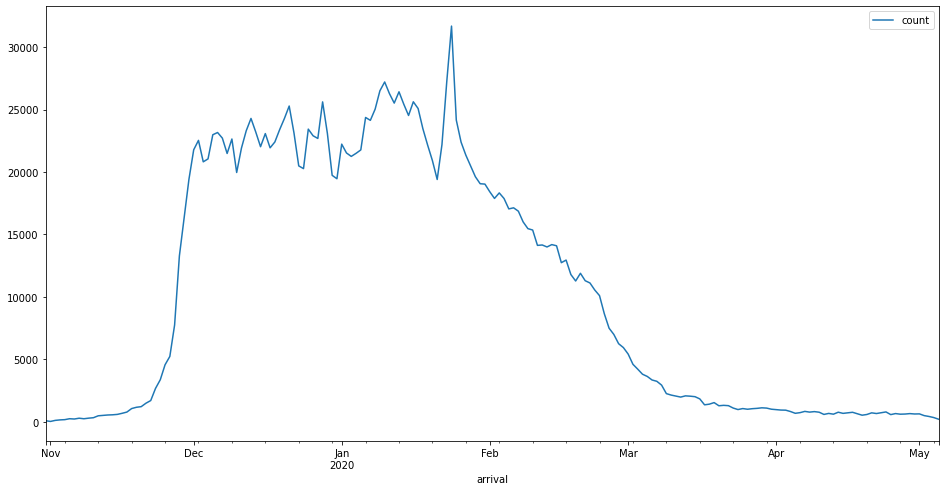

In [13]:

ds_y = pd.DataFrame(rm.groupby('arrival')['count'].sum())
ds_y.index=  pd.to_datetime(ds_y.index, format='%Y%m%d')

# 날자별 입국자(로밍등록자) 정리 dataset 확인
ds_y.plot(figsize=(16,8))
ds_y

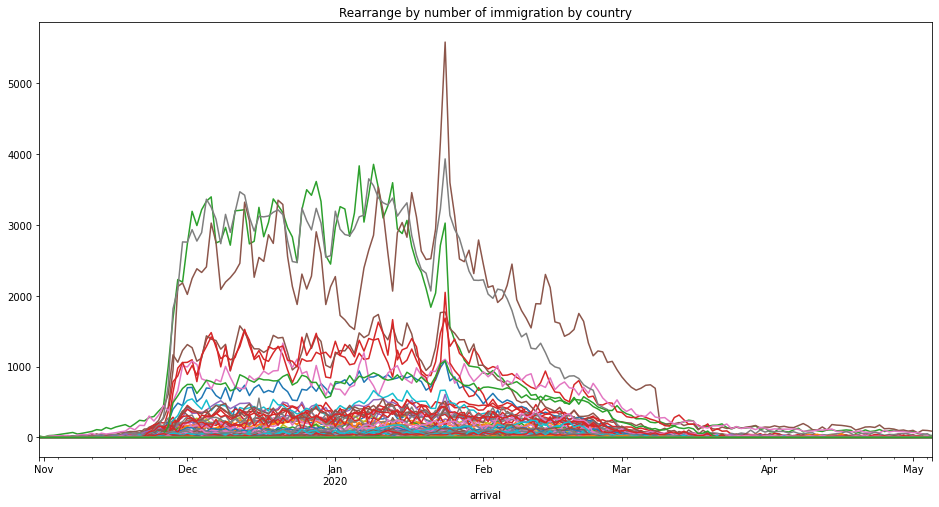

In [14]:

ar_iso = pd.DataFrame(rm.groupby(['arrival','iso'])['count'].sum())
rows = []
date = None
r = None
for row in ar_iso.iterrows():
    if date == row[0][0]:
        pass
    else:
        if not r is None:
            rows.append(r)
        r = {}
    r['arrival'] = row[0][0]
    r[row[0][1]] = row[1][0]
    date = row[0][0]
rows.append(r)
ds_iso = pd.DataFrame(rows)
ds_iso.fillna(0, inplace=True)
ds_iso = ds_iso.set_index('arrival')
#ds_iso['total'] = ar['count']
ds_iso.index =  ds_iso.index.astype('object')
#index을 datetime 으로 casting 한다.
ds_iso.index =  pd.to_datetime(ds_iso.index, format='%Y%m%d')
ds_iso.plot(legend=False,figsize=(16,8),title="Rearrange by number of immigration by country")

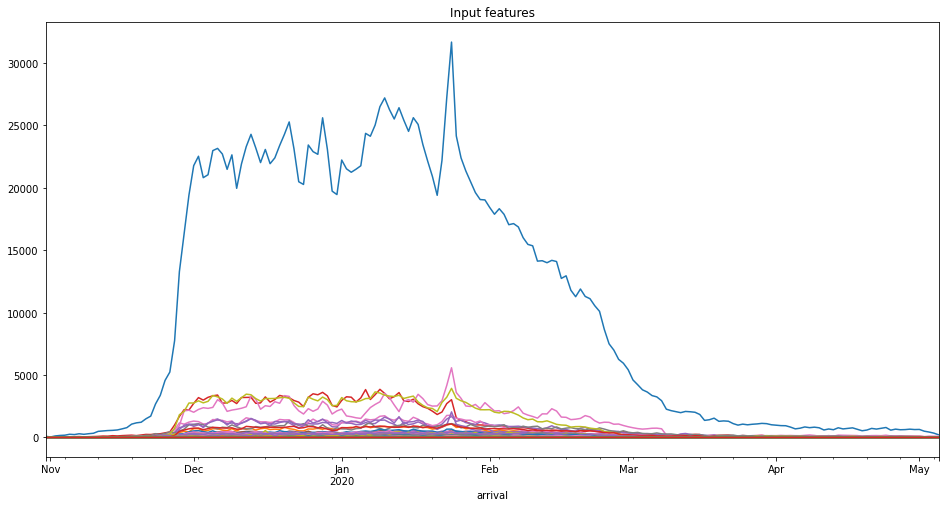

In [15]:
ds_y_iso = ds_y.join(ds_iso) # / np.max(ds_y.max())
ds_y_iso.plot(legend=False,figsize=(16,8),title='Input features')

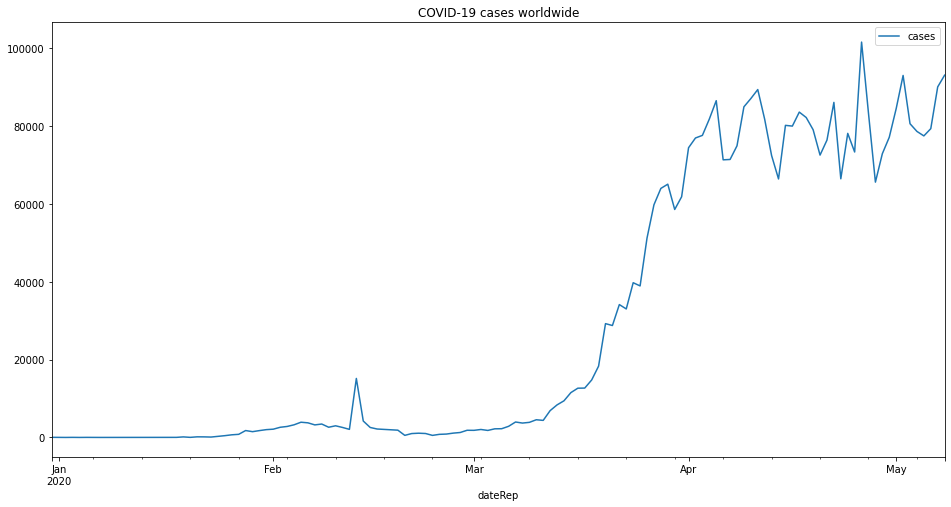

In [16]:
# 추가 데이터
# COVID-19 word wide dataset
# https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data

ds_cov_tp = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv",encoding="utf-8")
ds_cov = pd.DataFrame(ds_cov_tp.groupby('dateRep')['cases'].sum())
#date column을 datetime 으로 casting 한다.
ds_cov.index =  pd.to_datetime(ds_cov.index, format='%d/%m/%Y')
ds_cov = ds_cov.sort_index()
ds_cov.plot(figsize=(16,8),title='COVID-19 cases worldwide')


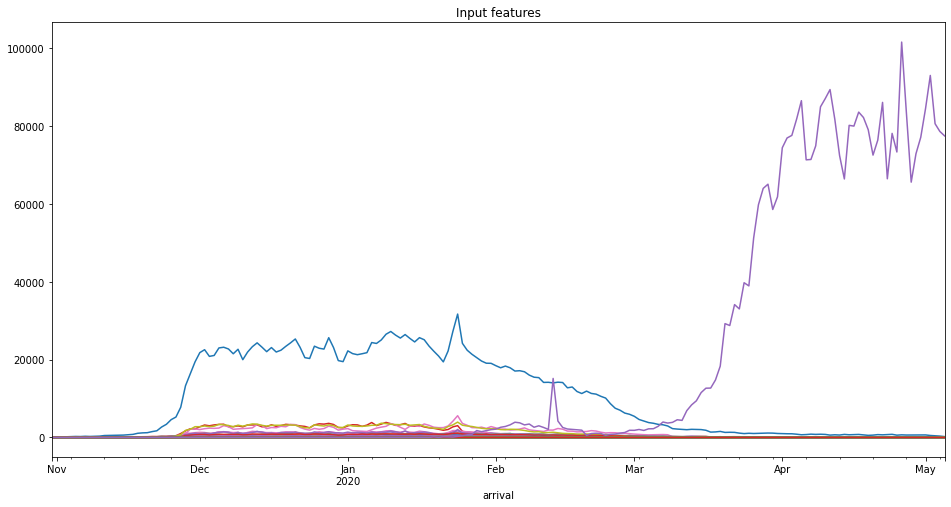

In [17]:
ds_y_iso_cov = ds_y_iso.join(ds_cov).fillna(0)
ds_y_iso_cov.plot(legend=False,figsize=(16,8),title='Input features')

In [18]:
# 뉴스 기사 정보를 읽어서... 나뉘어 있는 Dataset을 합친다.
ns1 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0406/NewsList.xls")
ns2 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0429/NewsList.xls")
ns3 = pd.read_excel("https://raw.githubusercontent.com/dolmani38/ai_corona/master/corona_contest_data_0506/NewsList.xls")

ds_ns_tp =pd.concat([ns1, ns2, ns3], ignore_index=True, sort=False)
ds_ns_tp

,파일명,제목,URL,수집일자,게시일자,채널명,감염병명,분류명
0,AFRO2019120200003,WHO supports Angola’s Government efforts to en...,https://www.afro.who.int/news/who-supports-ang...,2019-12-02 21:00:16.0,2019-12-02 00:00:00,AFRO,Poliomyelitis,Viral
1,AFRO2019120300001,African First Ladies laud progress against HIV...,https://www.afro.who.int/news/african-first-la...,2019-12-03 00:00:17.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
2,AFRO2019120300002,Eritrea Observed World AIDS Day 2019,https://www.afro.who.int/news/eritrea-observed...,2019-12-03 00:00:18.0,2019-12-02 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
3,AFRO2019120400003,West and Central Africa Expands Access to HIV ...,https://www.afro.who.int/news/west-and-central...,2019-12-04 03:00:14.0,2019-12-03 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
4,AFRO2019120400004,Nearly 23 million voluntary male medical circu...,https://www.afro.who.int/news/nearly-23-millio...,2019-12-04 22:00:14.0,2019-12-04 00:00:00,AFRO,Acquired immuno deficiency syndrome,Viral
...,...,...,...,...,...,...,...,...
112608,XINH2020050500081,Russia's top spacecraft designer reportedly di...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:06:31,Xinhua,COVID-19,Viral
112609,XINH2020050500083,Glimpse of a world under pandemic,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-05 23:01:00.0,2020-05-05 21:00:35,Xinhua,COVID-19,Viral
112610,XINH2020050600003,Chinese clinical experience on COVID-19 treatm...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 00:00:51.0,2020-05-05 22:03:48,Xinhua,COVID-19,Viral
112611,XINH2020050600005,Volvo Cars sales in China returns to growth in...,http://www.xinhuanet.com/english/2020-05/05/c_...,2020-05-06 01:00:57.0,2020-05-05 23:39:14,Xinhua,COVID-19,Viral


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

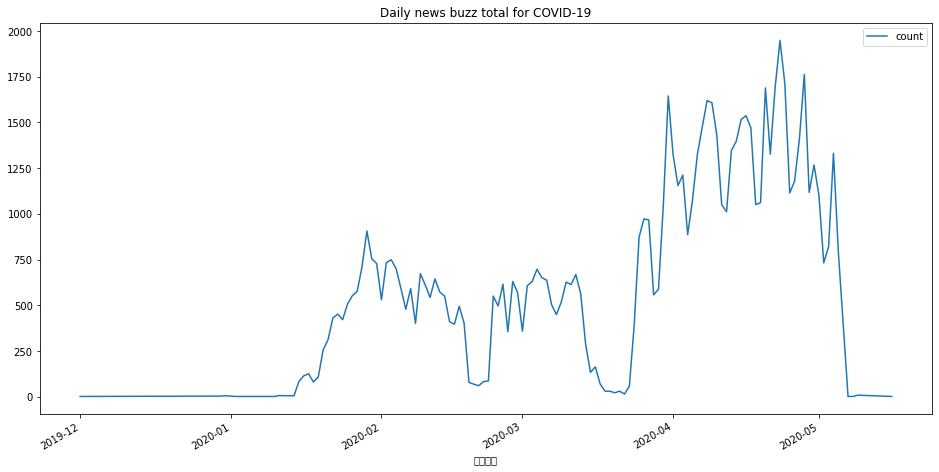

In [19]:
# ['감염병명'] == 'COVID-19' 인 것만 선별하여 일별 뉴스 발생량 구성 

ds_ns_tp = ds_ns_tp.loc[ds_ns_tp['감염병명'] == 'COVID-19']
ds_ns_tp['게시일자'] =  ds_ns_tp['게시일자'].str[:10]
ds_ns = pd.DataFrame(ds_ns_tp.groupby('게시일자')['감염병명'].count())
ds_ns = ds_ns.loc[ds_ns.index >= '2019-10-31']
ds_ns.index = pd.to_datetime(ds_ns.index, format='%Y-%m-%d')
ds_ns = ds_ns.rename(columns={"감염병명":"count"})
ds_ns.plot(figsize=(16,8),title="Daily news buzz total for COVID-19")


In [20]:
###########################################################################################################
# dolmani38의 google drive에서 corpus_embeddings.emb 의 다운로드                                          #
# dolmani38이외 Test 사용자는 이번 Cell은 실행하지 말고 다음 Cell에서 corpus_embeddings.emb를 만드세요.   #
###########################################################################################################
if True == 1:
  !pip install PyDrive
  import logging
  logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user(clear_output=False)
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  downloaded = drive.CreateFile({"id":"1FN7V0RxGACTNkusH9iQgFjXhicv1Lzei"})   # replace the id with id of file you want to access
  downloaded.GetContentFile("corpus_embeddings.emb")        # replace the file name with your file

  import os.path
  from os import path

  if path.exists("corpus_embeddings.emb"):
      print("Download complete!!")

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=pvWDO480Bt1HNDBwKcak1k9Jr5VQkM&code_challenge=Lhadg-2yPdWftqie292CwE6z3Metm1OhOrASM0lycc8&prompt=consent&code_challenge_method=S256&access_type=offline

Enter verification code: ··········
Download complete!!


In [21]:
# 			1.2.3.2 News의 BERT embedding

# 실 Contents는 사용하지 않고 title만 BERT embedding 처리...
# 시간 상당히 오래 걸림, 약 1시간 30분

#Start BERT embedding for news title...81785
#Length of corpus:81785
#Complete!!
#shape of corpus_embeddings :  (81785, 768)
#length of corpus :  81785
#End... elapsed time : 1:26:13.748154

# Sentence Transformers: Multilingual Sentence Embeddings using BERT / RoBERTa / XLM-RoBERTa & Co. with PyTorch
# https://github.com/UKPLab/sentence-transformers

!pip install -U sentence-transformers

from timeit import default_timer as timer
from datetime import timedelta
import os.path
from os import path
import dill
from sentence_transformers import SentenceTransformer
import scipy.spatial

start = timer()

# embedder download...
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

print("Start BERT embedding for news title...{}".format(len(ds_ns_tp)))

# 뉴스 title만 corpus로 추출
# 기사 내용도 할수는 있으나 시간 넘 걸림...
corpus = []
for row in ds_ns_tp.iterrows():
    file_name = row[1][0]
    title = str(row[1][1])
    pub_datetime = row[1][4]
    corpus.append(title.lower())
    #print("{},{},{}".format(file_name,pub_datetime,title))

print("Length of corpus:{}".format(len(corpus)))

if path.exists("corpus_embeddings.emb"):
    print("load from corpus_embeddings file...")
    file = open("corpus_embeddings.emb", 'rb')
    corpus_embeddings = dill.load(file)
    file.close()

else:
    corpus_embeddings = embedder.encode(corpus,show_progress_bar=True)   

    print("Wait! saving corpus_embeddings...")    
    file = open("corpus_embeddings.emb", 'wb')
    dill.dump(corpus_embeddings, file)
    file.close()

print("Complete!!")

corpus_embeddings = np.asarray(corpus_embeddings)        
print("shape of corpus_embeddings : ",corpus_embeddings.shape)
print("length of corpus : ",len(corpus))

#temp_ds = cov_news #.head(10)
docv_model = {}
for i, row in enumerate(ds_ns_tp.iterrows()):
    docv_model[row[1][0]] = corpus_embeddings[i]

len(docv_model)

end = timer()

print("End... elapsed time : {}".format(timedelta(seconds=end-start)))

     |████████████████████████████████| 61kB 2.2MB/s 
     |████████████████████████████████| 645kB 7.9MB/s 
     |████████████████████████████████| 890kB 17.6MB/s 
     |████████████████████████████████| 3.8MB 26.1MB/s 
     |████████████████████████████████| 1.0MB 47.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=6b34fed817cc07891ba7054dbe3ff0fdf02f24a79d67eaf64953ec973e3a2413
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=cc03e9d4c463981c40e8dd0d5a465a1f3468f03eb5b5396a00f05270538cde76
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:18<00:00, 21.3MB/s]


Start BERT embedding for news title...81785
Length of corpus:81785
load from corpus_embeddings file...
Complete!!
shape of corpus_embeddings :  (81785, 768)
length of corpus :  81785
End... elapsed time : 0:00:45.985444


In [22]:
# 			1.2.3.3 News data의 feature 추출 (일종의 차원 축소)

# News에서 6개 feature 추출
# worse feature : 코로나 상황이 더 나빠지고 있다는 뉴스
# better feature : 상황이 좋아 지고 있나는 뉴스
# block feature : 격리, 입출입 차단 강화 관련 뉴스
# premit feature : 격리 해제, 입출입 완화 관련 뉴스
# yes_korea feature : 한국에 긍정적 내용 뉴스
# no_korea feature : 한국에 부정적 내용 뉴스

# 6개 feature를 추출하기 위해, 각 특성을 나타내는 간략한 sentence를 수동으로 만들고, 이를 전체 corpus_embeddings 에서 유사한 내용의 뉴스를 추출하여
# 해당 뉴스를 유사 내용으로 간주하고 labeling 한다.

def searchSentence(queries,Threshold_score=0.60, Topn=0,must_has_word=[]):
    index = {}
    n = len(queries)
    query_embeddings = embedder.encode(queries)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        for idx, distance in results[0:len(results) if Topn==0 else Topn]:
          score = 1-distance
          if not idx in index:
            index[idx] = 0.0
          if score > Threshold_score:
              if len(must_has_word) > 0:
                  if corpus[idx].strip().find(must_has_word[0]) >= 0:
                      index[idx] += float(score/n)
              else:
                  index[idx] += float(score/n)
              #print(corpus[idx].strip(), "(Score: %.4f)" % (1-distance))
    return index

ds_ns_tp.reset_index(inplace = True, drop = True) 

queries_dict = {
    'worse':([],['infected corona','infected coronavirus ','increase confirmed','increase Infections','infectious increase','confirmed case incease','deaths incease','patients incease','lack prepare','not prepared','lack medical','lack preparedness']),
    'better':([],['decrease confirmed','decrease Infections','infectious decrease','confirmed case decrease','No confirmed','No case','deaths decrease','patients decrease','send supplies','order supplies','donates supplies','gives supplies','situation stability','situation stable','remains stable']),
    'block':([],['immigrants block','immigrants restrict','immigration block','immigration restrict','entrants block','entrants restrict','entry block','entry restrict','tourist block','tourist restrict','tourist Isolation','traveler block','traveler restrict','traveler Isolation','immigrants quarantine','entrants quarantine','entry quarantine','tourist quarantine','reinforce quarantine','reinforce diagnosis']),
    'permit':([],['immigrants permit','immigrants ease','immigration permit','immigration ease','entrants permit','entrants ease','entry permit','entry ease','tourist permit','tourist ease','release tourist ','traveler permit','release quarantine','release quarantine']),
    'yes_korea':(['korea'],['korea decrease confirmed','korea decrease Infections','korea infectious decrease','korea confirmed case decrease','korea No confirmed','korea No case','korea deaths decrease','korea patients decrease','korea send supplies','korea order supplies','korea donates supplies','korea gives supplies','korea situation stability','korea situation stable','korea remains stable','korea immigrants permit','korea immigrants ease','korea immigration permit','korea immigration ease','korea entrants permit','korea entrants ease','korea entry permit','korea entry ease','korea tourist permit','korea tourist ease','korea release tourist ','korea traveler permit','korea release quarantine','korea release quarantine']),
    'no_korea':(['korea'],['korea infected corona','korea infected coronavirus ','korea increase confirmed','korea increase Infections','korea infectious increase','korea confirmed case incease','korea deaths incease','korea patients incease','korea lack prepare','korea not prepared','korea lack medical','korea lack preparedness','korea immigrants block','korea immigrants restrict','korea immigration block','korea immigration restrict','korea entrants block','korea entrants restrict','korea entry block','korea entry restrict','korea tourist block','korea tourist restrict','korea tourist Isolation','korea traveler block','korea traveler restrict','korea traveler Isolation','korea immigrants quarantine','korea entrants quarantine','korea entry quarantine','korea tourist quarantine','korea reinforce quarantine','korea reinforce diagnosis'])
}
# Query sentences:

for query_key in queries_dict.keys():
  ds_ns_tp[query_key] = 0
  idxs = searchSentence(queries_dict[query_key][1],Threshold_score = 0.6,must_has_word=queries_dict[query_key][0])
  print('{} result rows:{} query count:{}'.format(query_key,len(idxs),len(queries_dict[query_key][1])))
  ds_ns_tp.loc[list(idxs.keys()),query_key] = list(idxs.values())

ds_ns_tp[['게시일자','worse','better','block','permit','yes_korea','no_korea','제목']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


worse result rows:81785 query count:12


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


better result rows:81785 query count:15
block result rows:81785 query count:20
permit result rows:81785 query count:14
yes_korea result rows:81785 query count:29
no_korea result rows:81785 query count:32


,게시일자,worse,better,block,permit,yes_korea,no_korea,제목
0,2020-01-25,0.054946,0.0,0.0,0.0,0.0,0.0,Rwanda Public Notice on Novel Coronavirus
1,2020-01-31,0.000000,0.0,0.0,0.0,0.0,0.0,WHO ramps up preparedness for novel coronaviru...
2,2020-02-01,0.051934,0.0,0.0,0.0,0.0,0.0,Rwanda hastens safety measures against novel c...
3,2020-02-02,0.000000,0.0,0.0,0.0,0.0,0.0,Eritrea Strengthening Preparedness to 2019 nov...
4,2020-02-04,0.000000,0.0,0.0,0.0,0.0,0.0,WHO supports Botswana’s preparedness and respo...
...,...,...,...,...,...,...,...,...
81780,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,"Spotlight: Europeans restart ""normal"" life in ..."
81781,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Russia's top spacecraft designer reportedly di...
81782,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Glimpse of a world under pandemic
81783,2020-05-05,0.000000,0.0,0.0,0.0,0.0,0.0,Chinese clinical experience on COVID-19 treatm...


In [23]:
# 6개 feature를 일자 기준 하나의 dataframe으로 join

cov_1 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['worse'].sum())
cov_2 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['better'].sum())
cov_3 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['block'].sum())
cov_4 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['permit'].sum())
cov_5 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['yes_korea'].sum())
cov_6 = pd.DataFrame(ds_ns_tp.groupby('게시일자')['no_korea'].sum())

ds_ns_cov = ds_ns.join(cov_1).join(cov_2).join(cov_3).join(cov_4).join(cov_5).join(cov_6)
ds_ns_cov

,count,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,,
2019-12-01,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,2,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,3,0.058952,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,5,0.170601,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-05,793,5.810915,0.516218,0.435219,0.223337,0.0,0.0
2020-05-07,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

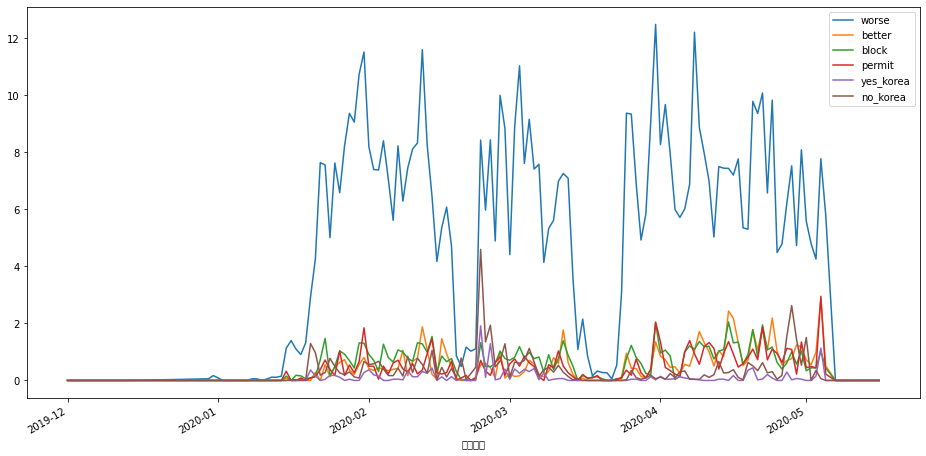

In [24]:
# 추출된 feature의 추세 확인
ds_ns_cov.plot(y=['worse','better','block','permit','yes_korea','no_korea'],figsize=(16,8))

,worse,better,block,permit,yes_korea,no_korea
게시일자,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-14,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2019-12-30,0.019651,0.000000,0.000000,0.000000,0.0,0.0
2019-12-31,0.034120,0.000000,0.000000,0.000000,0.0,0.0
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...
2020-05-05,0.007328,0.000651,0.000549,0.000282,0.0,0.0
2020-05-07,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-05-08,0.000000,0.000000,0.000000,0.000000,0.0,0.0


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

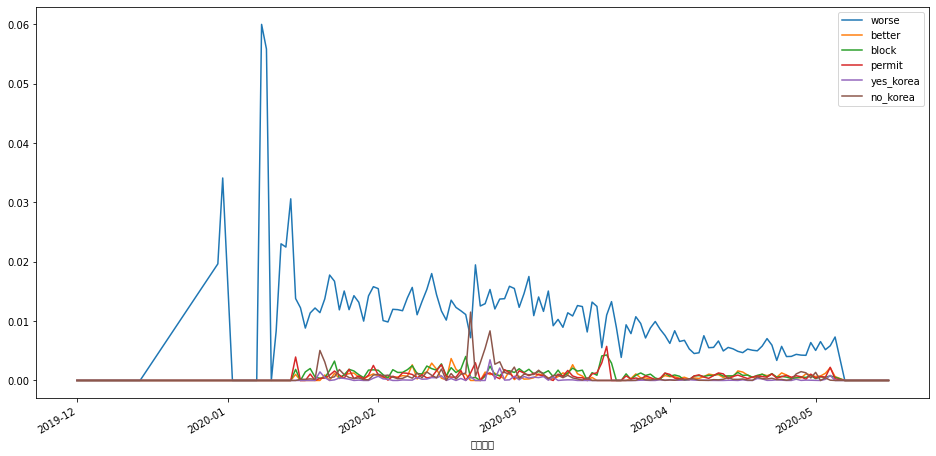

In [25]:
#			1.2.3.4 News feature의 Normalization

ds_ns_cov_n = pd.DataFrame({'worse':ds_ns_cov['worse']/ds_ns_cov['count']})
ds_ns_cov_n["better"] = ds_ns_cov['better']/ds_ns_cov['count']
ds_ns_cov_n["block"] = ds_ns_cov['block']/ds_ns_cov['count']
ds_ns_cov_n["permit"] = ds_ns_cov['permit']/ds_ns_cov['count']
ds_ns_cov_n["yes_korea"] = ds_ns_cov['yes_korea']/ds_ns_cov['count']
ds_ns_cov_n["no_korea"] = ds_ns_cov['no_korea']/ds_ns_cov['count']
# Normalization 한 feature의 추세 확인
ds_ns_cov_n.plot(figsize=(16,8))
ds_ns_cov_n

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_te

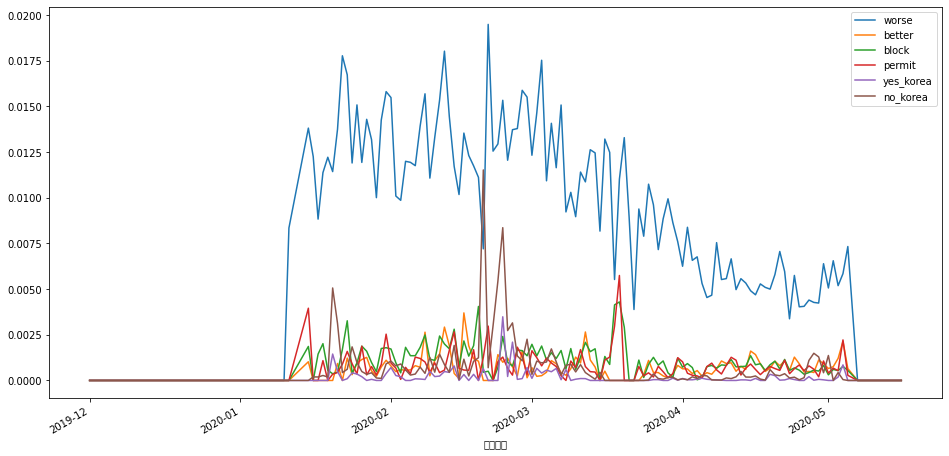

In [26]:
#			1.2.3.5 Outlier 제거

# worse 성분의 outlier filtering
ds_ns_cov_n_f = ds_ns_cov_n[ds_ns_cov_n["worse"] < 0.0195]
ds_ns_cov_n_f.plot(figsize=(16,8))

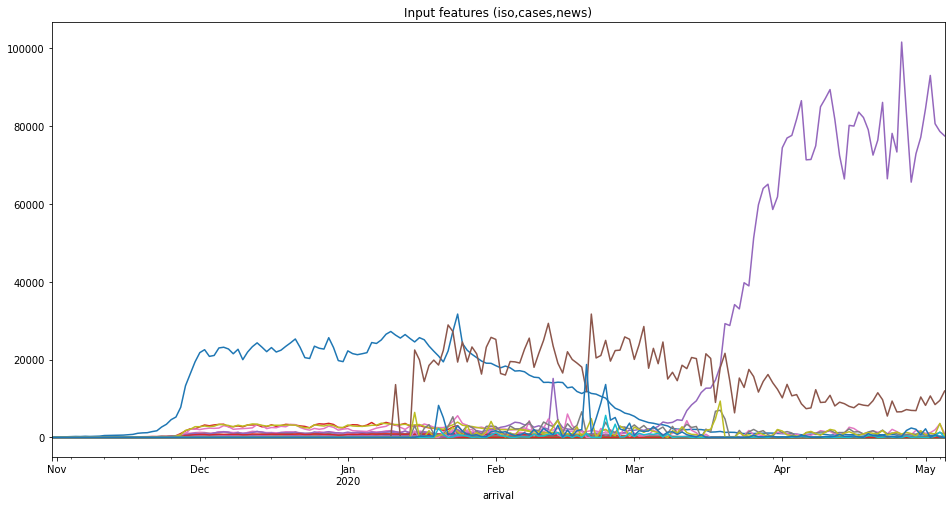

In [27]:
# ds_y 크기로 scale 조정
ds_ns_cov_n_f_s = (ds_ns_cov_n_f / np.max(ds_ns_cov_n_f.max())) * np.max(ds_y.max())
ds_y_iso_cov_ns = ds_y_iso_cov.join(ds_ns_cov_n_f_s).fillna(0)
ds_y_iso_cov_ns.plot(legend=False,figsize=(16,8),title='Input features (iso,cases,news)')

In [28]:
# Dataset 전처리 완료!!!!!!!!!!!!!!!!

ds_y_iso_cov_ns

,count,ae,at,cn,de,hk,jp,kh,kw,la,mm,my,no,pe,ph,pl,th,us,vn,hu,ma,mn,au,ch,fr,gb,in,iq,lk,qa,sg,uz,cz,dk,es,fi,id,nz,ru,sa,...,bz,bo,cy,na,pg,rw,bt,lr,mz,pr,tg,mk,an,cv,tt,md,ad,ga,gn,re,ky,bf,bj,cf,tc,ls,td,mr,to,ws,gm,ye,ml,cases,worse,better,block,permit,yes_korea,no_korea
arrival,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-31,91,3.0,3.0,20,3.0,6.0,6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,8.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-01,36,0.0,0.0,6,3.0,0.0,3,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-02,120,0.0,0.0,26,6.0,3.0,9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,19.0,3.0,0.0,0.0,0.0,6.0,3.0,6.0,3.0,6.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-03,159,3.0,3.0,30,0.0,12.0,14,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,13.0,21.0,6.0,3.0,0.0,0.0,0.0,3.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-04,179,12.0,3.0,40,3.0,3.0,10,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,6.0,24.0,9.0,3.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,6.0,6.0,3.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,641,6.0,9.0,85,25.0,28.0,100,0.0,0.0,0.0,0.0,6.0,0.0,3.0,35.0,3.0,22.0,68.0,29.0,6.0,0.0,0.0,15.0,3.0,6.0,3.0,0.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,3.0,0.0,35.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84440.0,8229.208252,1061.374612,501.685069,660.924079,0.000000,2221.129655
2020-05-02,502,3.0,13.0,56,20.0,9.0,65,19.0,0.0,0.0,0.0,3.0,0.0,0.0,9.0,0.0,10.0,67.0,26.0,0.0,0.0,0.0,12.0,0.0,3.0,6.0,0.0,0.0,0.0,6.0,7.0,3.0,0.0,0.0,0.0,0.0,6.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92964.0,10652.721643,1226.802938,983.162189,1095.694044,0.000000,0.000000
2020-05-03,434,3.0,0.0,51,12.0,9.0,102,3.0,3.0,0.0,0.0,3.0,0.0,0.0,6.0,0.0,6.0,49.0,45.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,6.0,8.0,0.0,0.0,0.0,3.0,0.0,22.0,0.0,12.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80568.0,8435.194937,1961.821330,873.372733,871.472627,304.678574,704.097801


input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 128)           92800     
_________________________________________________________________
activation_1 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           65664     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 128)            0       

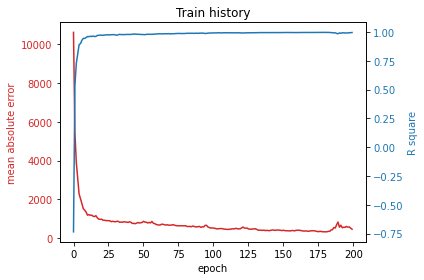

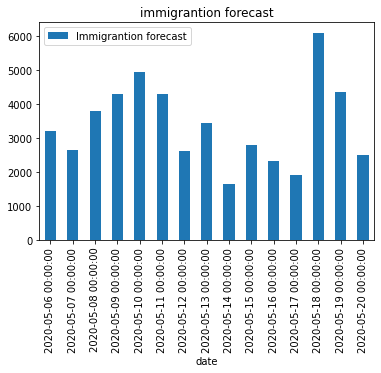

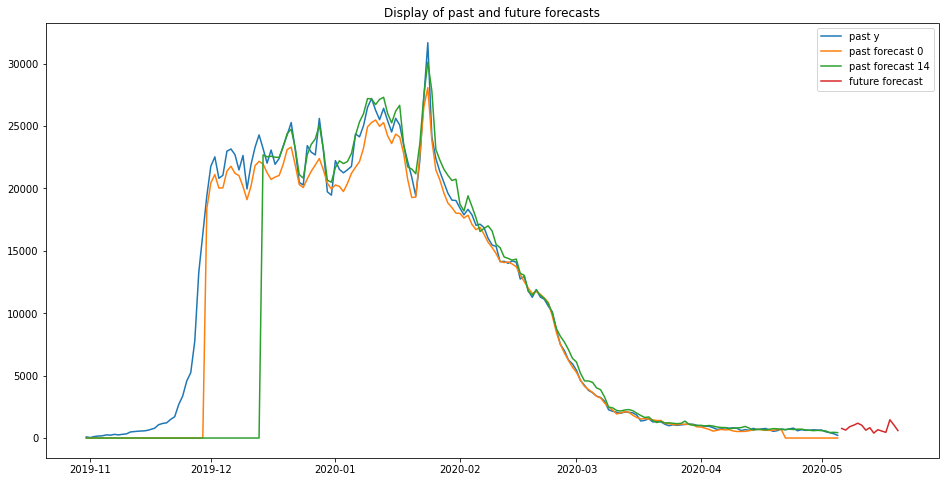

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,767.243408,3196
2020-05-07,637.707397,2657
2020-05-08,909.042969,3787
2020-05-09,1028.930420,4287
2020-05-10,1187.848389,4949
2020-05-11,1029.675171,4290
2020-05-12,629.365234,2622
2020-05-13,828.108765,3450
2020-05-14,397.529572,1656


In [29]:

# 30일간의 Data를 통해, 향후 15일을 1D Convolution Regression을 사용하여 예측.

window = 30
forecast=15

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y,window=window,forecast=forecast)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)
train_x_y,train_x_y.shape
test_x_y = model.predict(test_x)
ds_s_r = display_result(test_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecate'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r



input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 30, 128)           92800     
_________________________________________________________________
activation_5 (Activation)    (None, 30, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 15, 128)           65664     
_________________________________________________________________
activation_6 (Activation)    (None, 15, 128)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 128)            0       

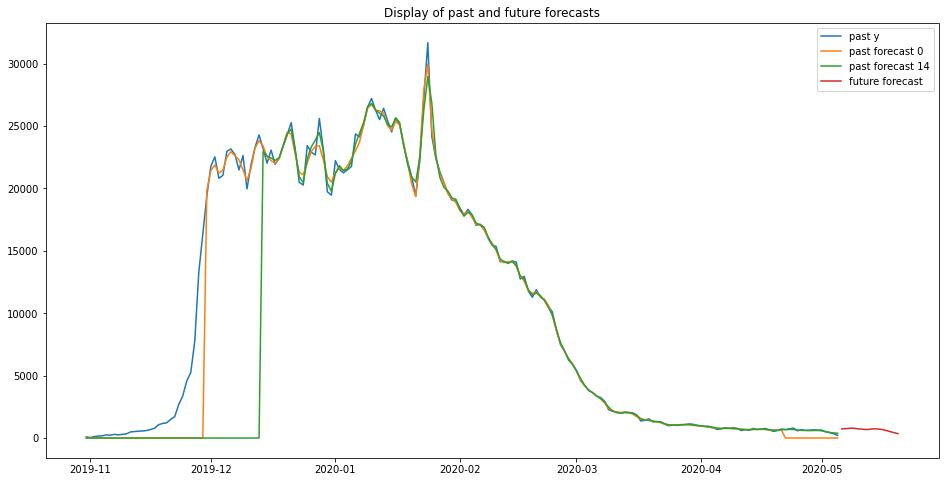

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,735,691 ~ 778,216.961731,2882 ~ 3243
2020-05-07,752,709 ~ 796,217.698502,2954 ~ 3316
2020-05-08,781,742 ~ 820,196.592255,3092 ~ 3419
2020-05-09,785,749 ~ 820,176.365189,3124 ~ 3417
2020-05-10,734,691 ~ 777,216.367325,2881 ~ 3241
2020-05-11,717,674 ~ 759,212.856720,2811 ~ 3165
2020-05-12,681,646 ~ 717,178.414215,2693 ~ 2989
2020-05-13,701,662 ~ 740,195.320236,2761 ~ 3086
2020-05-14,740,699 ~ 781,206.443420,2915 ~ 3258


In [30]:

# 동일한 방법으로 ensemble 에 의해 예측, 통계적 신뢰수준을 적용하여 로밍등록자 예측을 구간추정 한다.

import dill
from keras.models import model_from_json

def ensemble_train(train_x,train_y,ensemble_count=25,epoch=200):
    model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
    ensemble = []
    for i in range(ensemble_count):
      json_file = open("model.json", "r")
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json) 
      model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
      model,hist = train_model(model,train_x,train_y,epochs=epoch,trial=(i+1))
      ensemble.append(model)
        
    print("Wait! saving ensemble model...")    
    file = open("ensemble.mdl", 'wb')
    dill.dump(ensemble, file)
    file.close()

    print("Complete!!")
    return ensemble

# 		ensemble_predict method define~
def ensemble_predict(ensemble_model,input_x):
  if ensemble_model is None:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()
  ensemble_predit_y =  np.asarray([m.predict(input_x) for m in ensemble_model])
  predit_y = np.mean(ensemble_predit_y,axis=0)
  return predit_y, ensemble_predit_y


window = 30
forecast=15

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y,window=window,forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
test_x_y,ensemble_test_x_y = ensemble_predict(ensemble_model,test_x)
ds_s_r = statistical_results_analysis(ensemble_test_x_y,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout test_x: (1, 40, 181)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 40, 128)           92800     
_________________________________________________________________
activation_9 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 20, 128)           65664     
_________________________________________________________________
activation_10 (Activation)   (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 10, 128)           0    

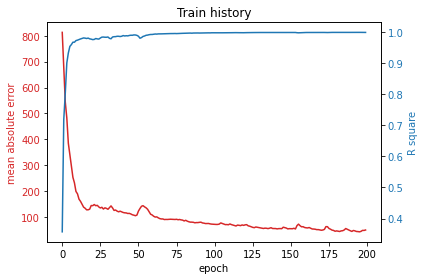

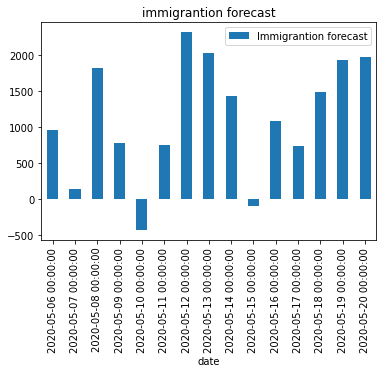

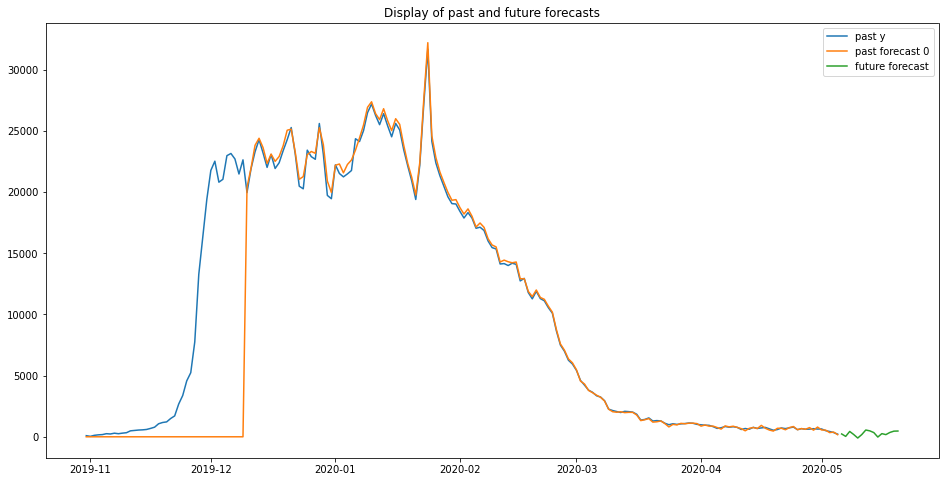

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,231.598923,964
2020-05-07,33.066555,137
2020-05-08,436.471436,1818
2020-05-09,185.354523,772
2020-05-10,-101.703812,-423
2020-05-11,180.399048,751
2020-05-12,554.515137,2310
2020-05-13,484.847992,2020
2020-05-14,344.397095,1434


In [31]:
# window = 40, forecast=1 로, 하루 앞을 예측하고 output을 재귀적으로 입력하여 15일까지를 예측한다.
#이렇게 하기 위해서는 trainset에서 y값이 x값과 같아야 한다.

def recursive_forecast(model,test_x,recursion=15):
  predict = []
  for i in range(recursion):
    predit_y = model.predict(test_x)
    predict.append(predit_y[0][0])
    new_test_x = test_x.reshape(test_x.shape[1],test_x.shape[2])
    new_test_x = np.concatenate((new_test_x, predit_y), axis=0)[1:window+1,:]
    test_x = new_test_x.reshape(1,new_test_x.shape[0],new_test_x.shape[1])
  return np.asarray(predict).reshape(1,recursion)

window = 40
forecast=1
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)
model = create_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)
test_x_y = recursive_forecast(model,test_x)
ds_s_r = display_result(test_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y,forecast_y= ds_s_r['Roaming register forecate'], comp_index=[0],window=window, forecast=forecast)
ds_s_r

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout test_x: (1, 40, 181)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 40, 128)           92800     
_________________________________________________________________
activation_13 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 128)           65664     
_________________________________________________________________
activation_14 (Activation)   (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 10, 128)           0    

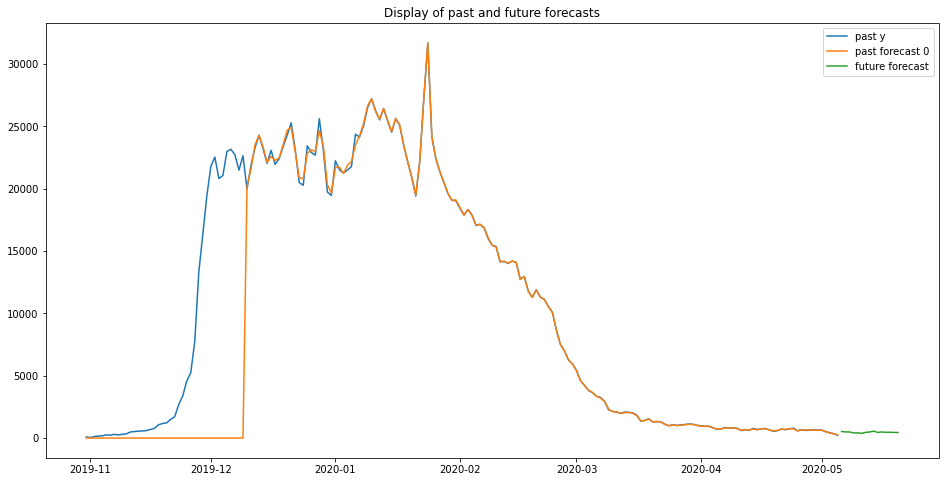

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,522,462 ~ 582,301.379791,1927 ~ 2428
2020-05-07,490,422 ~ 558,339.761841,1761 ~ 2326
2020-05-08,484,415 ~ 552,341.516632,1733 ~ 2300
2020-05-09,406,330 ~ 482,380.424866,1377 ~ 2009
2020-05-10,416,347 ~ 486,349.508270,1446 ~ 2027
2020-05-11,377,305 ~ 448,360.167938,1272 ~ 1870
2020-05-12,456,383 ~ 528,361.812042,1599 ~ 2200
2020-05-13,486,400 ~ 572,432.724640,1667 ~ 2386
2020-05-14,554,465 ~ 642,443.598297,1940 ~ 2677


In [32]:
# 		ensemble_predict method define~
def ensemble_recursive_forecast(ensemble_model,input_x):
  if ensemble_model is None:
    print("load from model file...")
    file = open("ensemble.mdl", 'rb')
    ensemble = dill.load(file)
    file.close()
  ensemble_predit_y =  np.asarray([recursive_forecast(m,input_x) for m in ensemble_model])
  predit_y = np.mean(ensemble_predit_y,axis=0)
  return predit_y, ensemble_predit_y

window = 40
forecast=1
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns,ds_y_iso_cov_ns,window=window, forecast=forecast)

ensemble_model = ensemble_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
test_x_y,ensemble_test_x_y = ensemble_recursive_forecast(ensemble_model,test_x)
ds_s_r = statistical_results_analysis(ensemble_test_x_y,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

In [0]:
# LSTM
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Activation, Flatten

def create_lstm_model(input_shape=(30, 1), output=15, metrics=['mae', r2]):
    model = Sequential()
    model.add(LSTM(units=256, return_sequences = True, input_shape=input_shape))
    #model.add(LSTM(units=512,return_sequences = True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    #model.add(Flatten())
    #model.add(Dense(1024))    
    model.add(Dense(output))
    model.add(Activation('linear'))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=metrics)

    model.summary()

    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()

    print("save to model.json")
    return model


input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 30, 256)           448512    
_________________________________________________________________
dropout_30 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_50 (Dense)             (None, 15)                1935      
_________________________________________________________________
activation_46 (Activation)   (None, 15)                0         
Total params: 647,567
Trainable params: 647,567
Non-trainable params: 0
________________________________________________________

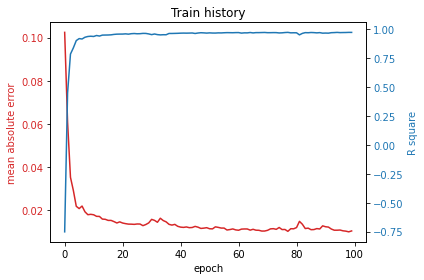

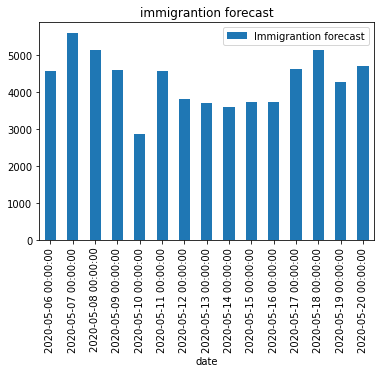

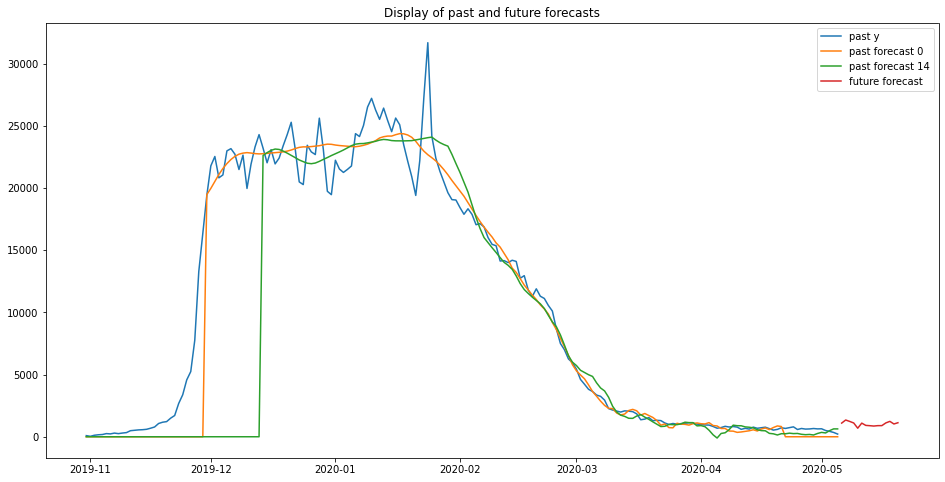

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,1097.468140,4572
2020-05-07,1346.613281,5610
2020-05-08,1231.922852,5133
2020-05-09,1106.597900,4610
2020-05-10,687.753784,2865
2020-05-11,1095.922852,4566
2020-05-12,913.624695,3806
2020-05-13,889.598389,3706
2020-05-14,860.714294,3586


In [132]:
# 30일간의 Data를 통해, 향후 15일을 LSTM을 사용하여 예측.

window = 30
forecast=15

max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y/max,window=window,forecast=forecast)
model = create_lstm_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)  * max
train_x_y,train_x_y.shape
test_x_y = model.predict(test_x)  * max
ds_s_r = display_result(test_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y, forecast_y= ds_s_r['Roaming register forecate'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r


In [134]:

def ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=200):
    model = create_lstm_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
    ensemble = []
    for i in range(ensemble_count):
      json_file = open("model.json", "r")
      loaded_model_json = json_file.read()
      json_file.close()
      model = model_from_json(loaded_model_json) 
      model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['mae',r2])
      model,hist = train_model(model,train_x,train_y,epochs=epoch,trial=(i+1))
      ensemble.append(model)
        
    print("Wait! saving ensemble model...")    
    file = open("ensemble.mdl", 'wb')
    dill.dump(ensemble, file)
    file.close()

    print("Complete!!")
    return ensemble


window = 30
forecast=15

max = np.max(ds_y_iso_cov_ns.max())
train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y/max,window=window,forecast=forecast)
ensemble_model = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x) 
test_x_y,ensemble_test_x_y = ensemble_predict(ensemble_model,test_x)
ds_s_r = statistical_results_analysis(ensemble_test_x_y*max,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0,14],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])


input x: (188, 181)
input y: (188, 1)
outout train_x: (144, 30, 181)
outout train_y: (144, 15)
outout test_x: (1, 30, 181)
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 30, 256)           448512    
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 256)           0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_53 (Dense)             (None, 15)                1935      
_________________________________________________________________
activation_51 (Activation)   (None, 15)                0         
Total params: 647,567
Trainable params: 647,567
Non-trainable params: 0
________________________________________________________

TypeError: ignored

Standard deviation: 805.2571207682291


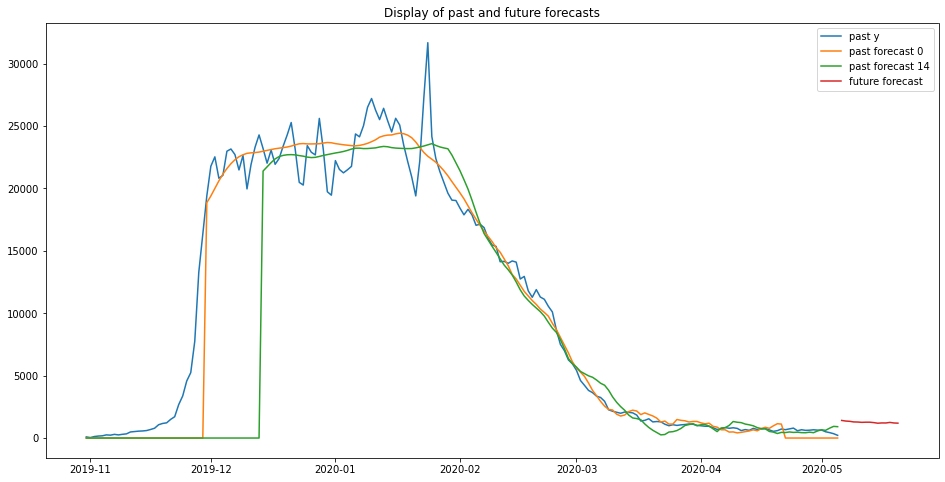

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,1410,1078 ~ 1741,787.611694,4493 ~ 7258
2020-05-07,1362,995 ~ 1729,870.623718,4148 ~ 7204
2020-05-08,1339,977 ~ 1700,857.286743,4074 ~ 7084
2020-05-09,1290,928 ~ 1652,859.829895,3867 ~ 6886
2020-05-10,1282,918 ~ 1646,863.999695,3825 ~ 6858
2020-05-11,1258,931 ~ 1584,775.845520,3880 ~ 6603
2020-05-12,1269,953 ~ 1586,752.074402,3971 ~ 6611
2020-05-13,1269,975 ~ 1564,698.404053,4064 ~ 6516
2020-05-14,1236,890 ~ 1582,821.577087,3710 ~ 6594


input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout test_x: (1, 40, 181)
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 40, 256)           448512    
_________________________________________________________________
dropout_32 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_54 (Dense)             (None, 181)               23349     
_________________________________________________________________
activation_52 (Activation)   (None, 181)               0         
Total params: 668,981
Trainable params: 668,981
Non-trainable params: 0
_____________________________________________________

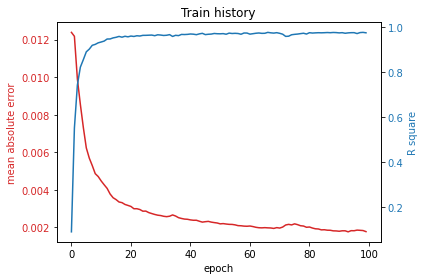

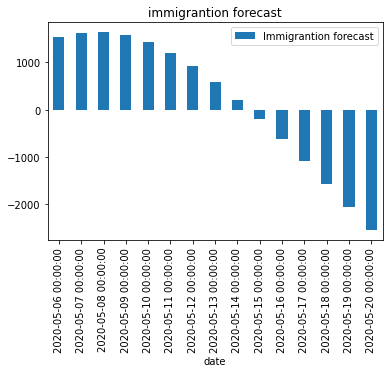

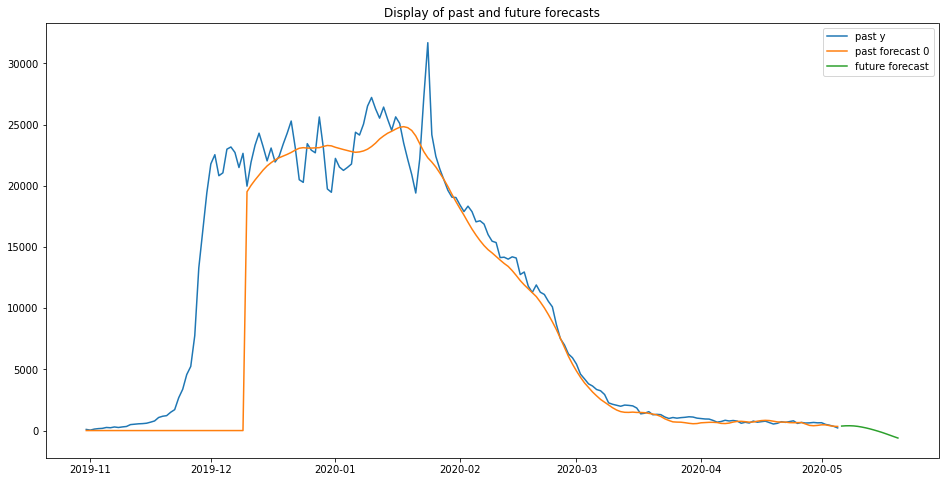

,Roaming register forecate,Immigrantion forecast
date,,
2020-05-06,367.389709,1530
2020-05-07,388.774445,1619
2020-05-08,393.160889,1638
2020-05-09,378.773407,1578
2020-05-10,342.346069,1426
2020-05-11,286.752167,1194
2020-05-12,219.677200,915
2020-05-13,140.854843,586
2020-05-14,50.951939,212


In [142]:
# window = 40, forecast=1 로, 하루 앞을 예측하고 output을 재귀적으로 입력하여 15일까지를 예측한다.
#이렇게 하기 위해서는 trainset에서 y값이 x값과 같아야 한다.

window = 40
forecast=1
max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y_iso_cov_ns/max,window=window, forecast=forecast)
model = create_lstm_model(input_shape=(train_x.shape[1], train_x.shape[2]),output=train_y.shape[1])  
model,hist = train_model(model,train_x,train_y,epochs=100,trial=1)
plot_train_result(hist)
train_x_y = model.predict(train_x)*max
test_x_y = recursive_forecast(model,test_x)*max
ds_s_r = display_result(test_x_y,ds_y)
compare_with_past_y(past_y=ds_y,comp_y=train_x_y,forecast_y= ds_s_r['Roaming register forecate'], comp_index=[0],window=window, forecast=forecast)
ds_s_r

input x: (188, 181)
input y: (188, 181)
outout train_x: (148, 40, 181)
outout train_y: (148, 181)
outout test_x: (1, 40, 181)
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 40, 256)           448512    
_________________________________________________________________
dropout_33 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_55 (Dense)             (None, 181)               23349     
_________________________________________________________________
activation_53 (Activation)   (None, 181)               0         
Total params: 668,981
Trainable params: 668,981
Non-trainable params: 0
_____________________________________________________

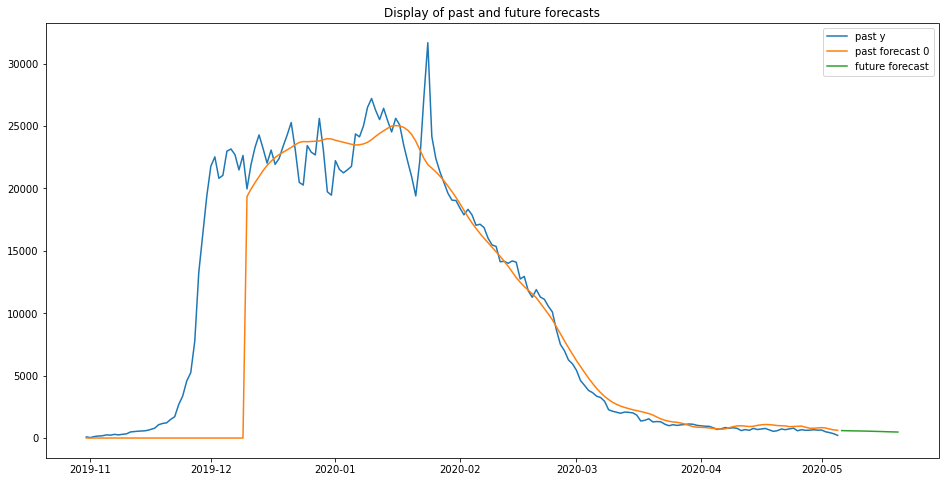

,Roaming register forecast(RRF),RRF within the 95% confidence interval,Standard deviation,Immigrantion forecast
date,,,,
2020-05-06,597,324 ~ 870,647.435974,1353 ~ 3626
2020-05-07,586,305 ~ 868,668.165283,1271 ~ 3617
2020-05-08,579,283 ~ 876,702.802490,1182 ~ 3650
2020-05-09,574,260 ~ 889,746.386475,1085 ~ 3705
2020-05-10,569,234 ~ 904,795.422791,975 ~ 3768
2020-05-11,562,205 ~ 919,847.371399,856 ~ 3831
2020-05-12,555,175 ~ 934,900.618042,732 ~ 3894
2020-05-13,547,145 ~ 949,954.353333,605 ~ 3956
2020-05-14,538,113 ~ 963,1007.996338,473 ~ 4012


In [143]:
window = 40
forecast=1

max = np.max(ds_y_iso_cov_ns.max())

train_x,train_y,test_x = create_timeseries_dataset(ds_y_iso_cov_ns/max,ds_y_iso_cov_ns/max,window=window, forecast=forecast)

ensemble_model = ensemble_lstrm_train(train_x,train_y,ensemble_count=25,epoch=50)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
test_x_y,ensemble_test_x_y = ensemble_recursive_forecast(ensemble_model,test_x)
ds_s_r = statistical_results_analysis(ensemble_test_x_y*max,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])

In [0]:
ensemble_model = ensemble_lstrm_train(train_x,train_y,ensemble_count=100,epoch=100)
train_x_y,ensemble_train_x_y = ensemble_predict(ensemble_model,train_x)
test_x_y,ensemble_test_x_y = ensemble_recursive_forecast(ensemble_model,test_x)
ds_s_r = statistical_results_analysis(ensemble_test_x_y*max,ds_y)
print('Standard deviation:',np.mean(ds_s_r['Standard deviation']))
compare_with_past_y(past_y=ds_y,comp_y=train_x_y*max, forecast_y= ds_s_r['Roaming register forecast(RRF)'],comp_index=[0],window=window,forecast=forecast)
ds_s_r.drop(columns=['min','max'])